# 1.0 - IMPORTS

## 1.1 - LIBRARIES

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import random
import inflection
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import folium
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score, accuracy_score, f1_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
%matplotlib inline

## 1.2 - LOAD DATA

In [2]:
df_raw = pd.read_csv('../dataset/train.csv', low_memory= False)

## 1.3 - HELPER FUNCTIONS

### 1.3.1 - RENAME COLUMNS FUNCTION

In [3]:
def rename_columns(df):
    old_columns = df.columns
    new_columns = old_columns.map(lambda x: x.lower())
    df.columns = new_columns
    return df.columns

### 1.3.2 - OUTLIERS VOLUMETRY

In [4]:
def outliers_volumetry(data):
    
    df_num = pd.DataFrame()
    df_num = data.select_dtypes(exclude = 'object')
    outlier = []

    for i in df_num.columns:
        q1 = np.quantile(df_num[i], 0.25)
        q3 = np.quantile(df_num[i], 0.75)
        interquartile_distance = q3 - q1
        upper_limit = q3 + 1.5 * interquartile_distance
        lower_limit = q1 - 1.5 * interquartile_distance
        outliers = 0
        for j in df_num.index:
            if df_num[i][j] > upper_limit:
                outliers = outliers + 1
            elif df_num[i][j] < lower_limit:
                outliers = outliers + 1
            else:
                pass

        outlier.append(outliers)

    df_outlier = pd.DataFrame()
    df_outlier['attributes']    = df_num.columns
    df_outlier['quantity']      =   outlier
    df_outlier['percentual']    =   (outlier/df_num['restaurant_latitude'].count())*100

    return df_outlier         
        


### 1.3.3 - PLOT DIMENSIONS

In [5]:
sns.set(rc = {'figure.figsize':(13,5)})

# 2.0 - DATA CLEANING

In [6]:
df2 = df_raw.copy()

## 2.1 - RENAME COLUMNS

In [7]:
rename_columns(df2)

Index(['id', 'delivery_person_id', 'delivery_person_age',
       'delivery_person_ratings', 'restaurant_latitude',
       'restaurant_longitude', 'delivery_location_latitude',
       'delivery_location_longitude', 'order_date', 'time_orderd',
       'time_order_picked', 'weatherconditions', 'road_traffic_density',
       'vehicle_condition', 'type_of_order', 'type_of_vehicle',
       'multiple_deliveries', 'festival', 'city', 'time_taken(min)'],
      dtype='object')

## 2.2 - DATA DIMENSIONS

In [8]:
rows = df2.shape[0]
cols = df2.shape[1]
print('The Dataset have {} columns and {} rows.\n'.format(cols, rows))
print('Number of unique elements for each feature.\n')
print(df2.apply(lambda x: x.unique().shape[0]))

The Dataset have 20 columns and 45593 rows.

Number of unique elements for each feature.

id                             45593
delivery_person_id              1320
delivery_person_age               23
delivery_person_ratings           29
restaurant_latitude              657
restaurant_longitude             518
delivery_location_latitude      4373
delivery_location_longitude     4373
order_date                        44
time_orderd                      177
time_order_picked                193
weatherconditions                  7
road_traffic_density               5
vehicle_condition                  4
type_of_order                      4
type_of_vehicle                    4
multiple_deliveries                5
festival                           3
city                               4
time_taken(min)                   45
dtype: int64


## 2.3 - CHECK NAN

We can see that there are no NULL or NAN values ​​in the dataset. However, there are variables with 'NaN ' data, which we will need to change manually.

In [9]:
df2.isna().sum()

id                             0
delivery_person_id             0
delivery_person_age            0
delivery_person_ratings        0
restaurant_latitude            0
restaurant_longitude           0
delivery_location_latitude     0
delivery_location_longitude    0
order_date                     0
time_orderd                    0
time_order_picked              0
weatherconditions              0
road_traffic_density           0
vehicle_condition              0
type_of_order                  0
type_of_vehicle                0
multiple_deliveries            0
festival                       0
city                           0
time_taken(min)                0
dtype: int64

Checking the features that have space in their text ' ', and replacing the texts 'NaN '.

In [10]:
# Removing space within texts
df2['id']                 = df2['id'].str.replace(' ', '')
df2['delivery_person_id'] = df2['delivery_person_id'].str.replace(' ', '')
df2['type_of_order']      = df2['type_of_order'].str.replace(' ', '')
df2['type_of_vehicle']    = df2['type_of_vehicle'].str.replace(' ', '')

In [11]:
# Selecting features other than 'NaN '
df_dpa = df2['delivery_person_age'].loc[df2['delivery_person_age'] != 'NaN ']
# Converting to the native variable type and performing an average
df_dpa = df_dpa.astype(np.int64).mean()
df_dpa = np.round(df_dpa, 0)
# Applying a lambda function to replace values ​​equal to 'NaN ', with the arithmetic mean of the delivery age
df2['delivery_person_age'] = df2['delivery_person_age'].apply(lambda x: df_dpa if x == 'NaN ' else x)

In [12]:
# Selecting features other than 'NaN '
df_dpr = df2['delivery_person_ratings'].loc[df2['delivery_person_ratings'] != 'NaN ']
# Converting to the native variable type and performing an average
df_dpr = pd.to_numeric(df_dpr, errors='coerce').mean()
df_dpr = np.round(df_dpr, 1)
# Applying a lambda function to replace values ​​equal to 'NaN ', with the arithmetic mean of the delivery rate
df2['delivery_person_ratings'] = df2['delivery_person_ratings'].apply(lambda x: df_dpr if x == 'NaN ' else x)

In [13]:
# Selecting features other than 'NaN '
df_to = df2['time_orderd'].loc[df2['time_orderd'] != 'NaN ']
# Changing the variable type to native
df_to = pd.to_datetime(df_to, errors='coerce')
df_to = df_to.dt.strftime('%H:%M')
rv = random.choice(df_to)
df2['time_orderd'] = df2['time_orderd'].apply(lambda x: rv if x == 'NaN ' else x)

C:\Users\ErickVieira\AppData\Local\Temp\ipykernel_3120\3988063383.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_to = pd.to_datetime(df_to, errors='coerce')


In [14]:
# Replacing 'NaN ' with the value of the most repeated variable .mode()
df2['road_traffic_density'] = df2['road_traffic_density'].apply(lambda x: 'Low' if x == 'NaN ' else x)
df2['road_traffic_density'] = df2['road_traffic_density'].str.replace(' ', '')
df2['type_of_order'].unique()

array(['Snack', 'Drinks', 'Buffet', 'Meal'], dtype=object)

In [15]:
# Replacing 'NaN ' with the value of the most repeated variable .mode()
df2['multiple_deliveries'] = df2['multiple_deliveries'].apply(lambda x: '1' if x == 'NaN ' else x)
df2['multiple_deliveries'].unique()

array(['0', '1', '3', '2'], dtype=object)

In [16]:
# Replacing 'NaN ' with the value of the most repeated variable .mode()
df2['festival'] = df2['festival'].apply(lambda x: 'No' if x == 'NaN ' else x)
# Removing space within texts
df2['festival'] = df2['festival'].str.replace(' ', '')
df2['festival'].unique()

array(['No', 'Yes'], dtype=object)

In [17]:
# Replacing 'NaN ' with the value of the most repeated variable .mode()
df2['city'] = df2['city'].apply(lambda x: 'Metropolitian' if x == 'NaN ' else x)
# Removing space within texts
df2['city'] = df2['city'].str.replace(' ', '')
df2['city'].unique()

array(['Urban', 'Metropolitian', 'Semi-Urban'], dtype=object)

## 2.4 - DATA TYPES

In [18]:
df2.dtypes

id                              object
delivery_person_id              object
delivery_person_age             object
delivery_person_ratings         object
restaurant_latitude            float64
restaurant_longitude           float64
delivery_location_latitude     float64
delivery_location_longitude    float64
order_date                      object
time_orderd                     object
time_order_picked               object
weatherconditions               object
road_traffic_density            object
vehicle_condition                int64
type_of_order                   object
type_of_vehicle                 object
multiple_deliveries             object
festival                        object
city                            object
time_taken(min)                 object
dtype: object

In [19]:
df2['delivery_person_age']     = df2['delivery_person_age'].astype(np.int64)
df2['delivery_person_ratings'] = df2['delivery_person_ratings'].astype(float)
df2['order_date']              = pd.to_datetime(df2['order_date'])
df2['time_orderd']             = pd.to_datetime(df2['time_orderd'])
df2['time_order_picked']       = pd.to_datetime(df2['time_order_picked'])
df2['vehicle_condition']       = df2['vehicle_condition'].astype(np.int64)
df2['multiple_deliveries']     = df2['multiple_deliveries'].astype(np.int64)
# Removing the characters '(min) ', to convert the variable to an integer.
df2['time_taken(min)']         = df2['time_taken(min)'].str.replace('(min) ', '')
df2['time_taken(min)'] = df2['time_taken(min)'].astype(np.int64)

C:\Users\ErickVieira\AppData\Local\Temp\ipykernel_3120\1187491371.py:3: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df2['order_date']              = pd.to_datetime(df2['order_date'])
C:\Users\ErickVieira\AppData\Local\Temp\ipykernel_3120\1187491371.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df2['time_orderd']             = pd.to_datetime(df2['time_orderd'])
C:\Users\ErickVieira\AppData\Local\Temp\ipykernel_3120\1187491371.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df2['time_order_picked']       = pd.to_datetime(df2['time_order_picked'])


## 2.5 - OUTLIERS VOLUMETRY

Now let's check the volume of the outliers contained in the base:
Evaluating the characteristics that present the outliers, some have an average variation of less than 14%, among them are characteristics that we can maintain, such as Longitude of the Delivery Location and Longitude of the Restaurant. These are plausible characteristics to have outliers, as the location may have variations in mileage.

In [20]:
#function to set volumetry
outliers_volumetry(df2)

,attributes,quantity,percentual
0,delivery_person_age,53,0.116246
1,delivery_person_ratings,5345,11.723291
2,restaurant_latitude,431,0.945321
3,restaurant_longitude,4655,10.209901
4,delivery_location_latitude,0,0.000000
5,delivery_location_longitude,6516,14.291668
6,order_date,0,0.000000
7,time_orderd,430,0.943127
8,time_order_picked,1320,2.895181
9,vehicle_condition,0,0.000000


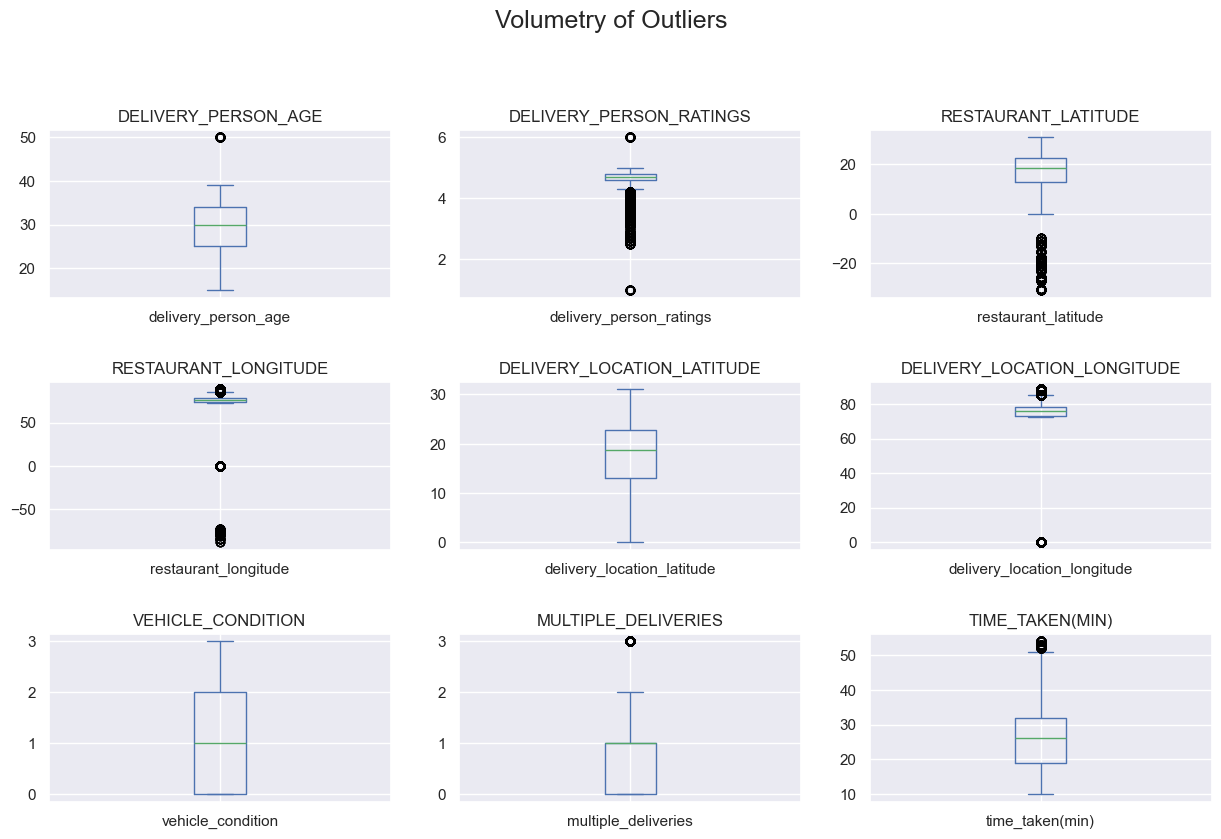

In [21]:
# Creating the subplots for the dashbord of the boxplot
df_numerical = df2.select_dtypes(exclude = ['object', 'datetime'])
plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("Volumetry of Outliers", fontsize=18)

# loop through the length of pointer and keep track of index
for n, pointer in enumerate(df_numerical.columns):
    
    # add a new subplot iteratively
    ax = plt.subplot(4, 3, n + 1)

    # create a boxplot for the pointer on the new subplot axis
    df_numerical[pointer].plot(kind='box', ax=ax)

    # chart formatting
    ax.set_title(pointer.upper())
    ax.set_xlabel("")

plt.show()

# 3.0 - STATISTIC DESCRIPTIVE

In [22]:
df3 = df2.copy()


In [23]:
df_num = pd.DataFrame()
df_num = df3.select_dtypes(exclude = ['object', 'datetime'])

# Central Tendency
# Mean & Median
central_tendency1 = pd.DataFrame(df_num.apply(lambda x: np.mean(x))).T
central_tendency2 = pd.DataFrame(df_num.apply(lambda x: np.median(x))).T

# Dispersion
#Standart Deviation - Min - Max - Range - Skew - Kurtosis
dispersion1 = pd.DataFrame(df_num.apply(lambda x: np.std(x))).T
dispersion2 = pd.DataFrame(df_num.apply((min))).T
dispersion3 = pd.DataFrame(df_num.apply((max))).T
dispersion4 = pd.DataFrame(df_num.apply(lambda x: x.min() - x.max())).T
dispersion5 = pd.DataFrame(df_num.apply(lambda x: x.skew())).T
dispersion6 = pd.DataFrame(df_num.apply(lambda x: x.kurtosis())).T
#Concat dataframe
metrics = pd.concat([central_tendency1, central_tendency2, dispersion1, dispersion2, dispersion3, dispersion4, dispersion5, dispersion6]).T.reset_index()
metrics.columns = ['Attributes', 'Mean', 'Median', 'STD', 'Min', 'Max', 'Range', 'Skew', 'Kurtosis']
metrics

,Attributes,Mean,Median,STD,Min,Max,Range,Skew,Kurtosis
0,delivery_person_age,29.584739,30.000000,5.696271,15.000000,50.000000,-35.000000,0.009802,-0.977111
1,delivery_person_ratings,4.632367,4.700000,0.327704,1.000000,6.000000,-5.000000,-2.532896,16.425679
2,restaurant_latitude,17.017729,18.546947,8.185019,-30.905562,30.914057,-61.819619,-1.361583,3.713716
3,restaurant_longitude,70.231332,75.898497,22.883396,-88.366217,88.433452,-176.799669,-3.220159,10.303039
4,delivery_location_latitude,17.465186,18.633934,7.335042,0.010000,31.054057,-31.044057,-0.701066,0.264346
5,delivery_location_longitude,70.845702,76.002574,21.118580,0.010000,88.563452,-88.553452,-2.956385,7.104451
6,vehicle_condition,1.023359,1.000000,0.839056,0.000000,3.000000,-3.000000,0.071853,-1.315002
7,multiple_deliveries,0.750225,1.000000,0.567424,0.000000,3.000000,-3.000000,0.298735,0.950328
8,time_taken(min),26.294607,26.000000,9.383703,10.000000,54.000000,-44.000000,0.485951,-0.310798


# 4.0 - FEATURE ENGINEERING

In [24]:
df4 = df3.copy()

In [25]:
# Converting hexadecimal ID column of type Object to base 16 int
df4['id'] = df4['id'].apply(lambda x: int(x, 16))

In [26]:
#Calculating the order preparation time by subtracting the time the ticket is issued from the preparation time
df4['time_preparation(min)'] = (df4['time_order_picked'] - df4['time_orderd']).dt.total_seconds() / 60
df4['time_preparation(min)'] = df4['time_preparation(min)'].apply(lambda x: np.abs(x) if x <= 0 else x)
df4['time_preparation(min)'] = df4['time_preparation(min)'].astype(np.int64)

# Extracting the time from the 'Time Orderd' attribute
df4['time_orderd'] = df4['time_orderd'].dt.strftime('%H:%M')
df4['time_order_picked'] = df4['time_order_picked'].dt.strftime('%H:%M')

In [27]:
#Creating a new feature with the period of the day, based on the time intervals in which orders are issued
df4['day_period'] = df4['time_orderd'].apply(lambda x: 'Morning' if (x >= '00:00') and (x <= '11:59') else 'Evening' if (x >= '12:00') and (x <= '17:59') else 'Night')

In [28]:
# Removing the term 'Conditions' from the attribute 'Weather Conditions', because the attribute already indicates that the value refers to a condition. And standardizing the column with snakecase.
df4.rename({'weatherconditions': 'weather_conditions'}, inplace = True, axis = 1)
df4['weather_conditions'] = df4['weather_conditions'].str.replace('conditions ', '')
# Replacing the ' NaN' value with the one that most repeats: 'Fog'
df4['weather_conditions'] = df4['weather_conditions'].str.replace(' ', '')
df4['weather_conditions'] = df4['weather_conditions'].apply(lambda x: 'Fog' if x == 'NaN' else x)

In [29]:
# Replacing the 'Jam' value for 'Extreme' of the 'Rad Traffic Density' attribute, for a better understanding of the variable.
df4['road_traffic_density'].replace({'Jam':'Extreme'}, inplace = True)

In [30]:
# Extracting the day of the week and the month from the 'Order Date' attribute and creating a new Feature.
df4['order_day_week'] = df4['order_date'].dt.day_name()
df4['order_day_month'] = df4['order_date'].dt.month_name()

In [31]:
df4['order_day_week'] = df4['order_day_week'].replace({'Sunday':'1 - Sunday','Monday': '2 - Monday', 'Tuesday': '3 - Tuesday' , 'Wednesday': '4 - Wednesday',
                                                       'Thursday': '5 - Thursday', 'Friday': '6 - Friday', 'Saturday': '7 - Saturday'})

In [32]:
#Extracting the week number
df4['number_week']  = df4['order_date'].apply(lambda data: data.strftime('%U'))
df4['number_week'] = df4['number_week'].astype(np.int64)

In [33]:
# Creating a new Feature based on the variables of the 'Delivery Person ratings' attribute, to help measure the transition of scale between assessments.
df4['ratings_level'] = df4['delivery_person_ratings'].apply(lambda x: 'Excellent' if x >= 5 else 'Good' if (x <= 4.9) and (x > 4) else 'Medium' if (x <= 3.9) and (x > 2.9) else 'Bad')

In [34]:
# Creating a delivery time range
bins = [1, 10, 20, 25, 30, 35, 40, 45, 50, 55]
df4['time_range'] = pd.cut(df4['time_taken(min)'], bins = bins) 
df4['time_range'] = df4['time_range'].astype(str)

In [35]:
# Rearranging the columns
new_order = ['id', 'delivery_person_id', 'delivery_person_age', 'delivery_person_ratings', 'ratings_level', 
               'restaurant_latitude', 'restaurant_longitude', 'delivery_location_latitude', 'delivery_location_longitude', 
               'order_date', 'number_week', 'order_day_week', 'order_day_month', 'day_period', 'time_orderd', 'time_order_picked', 'time_preparation(min)',
               'weather_conditions', 'road_traffic_density', 'vehicle_condition', 'type_of_order', 'type_of_vehicle', 'multiple_deliveries', 
               'festival', 'city', 'time_range', 'time_taken(min)']

df4 = df4[new_order]

# 5.0 EXPLORATORY DATA ANALYSIS (EDA)

In [36]:
df5 = df4.copy()

## 5.1 - UNIVARIATE ANALYSIS

### 5.1.1 - TARGET VARIABLE

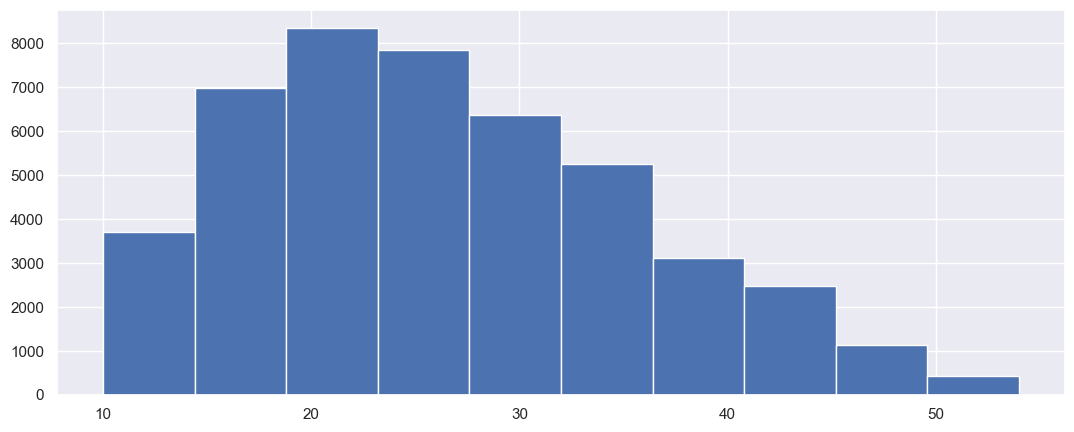

In [37]:
df5['time_taken(min)'].hist()
plt.show()

### 5.1.2 - TOTAL QUANTITY OF ORDERS

In [38]:
df5['id'].count()

45593

### 5.1.3 - TOTAL QUANTITY OF ORDERS

In [39]:
df5['delivery_person_id'].nunique()

1320

### 5.1.4 - TOTAL QUANTITY OF ORDERS

In [40]:
np.round(df5['delivery_person_age'].mean())

30.0

### 5.1.5 - AVERAGE RATINGS

In [41]:
np.round(df5['delivery_person_ratings'].mean(), 1)

4.6

### 5.1.6 - TOP 10 FASTEST DELIVERIERS

In [42]:
df5.groupby(['delivery_person_id'])['time_taken(min)'].max().reset_index().sort_values(['time_taken(min)'], ascending=True).drop_duplicates(subset=['delivery_person_id']).head(10)

,delivery_person_id,time_taken(min)
827,KOCRES16DEL03,27
479,DEHRES20DEL03,28
146,AURGRES08DEL03,29
266,BHPRES08DEL03,29
89,ALHRES09DEL03,30
245,BHPRES01DEL03,30
959,LUDHRES20DEL03,31
131,AURGRES03DEL03,31
860,KOLRES06DEL03,31
164,AURGRES15DEL03,31


### 5.1.7 - TOP 10 SLOWEST DELIVERIERS

In [43]:
df5.groupby(['delivery_person_id'])['time_taken(min)'].max().reset_index().sort_values(['time_taken(min)'], ascending=False).drop_duplicates(subset=['delivery_person_id']).head(10)

,delivery_person_id,time_taken(min)
408,COIMBRES17DEL01,54
975,MUMRES05DEL01,54
419,COIMBRES20DEL03,54
1179,RANCHIRES14DEL01,54
1008,MUMRES17DEL01,54
1174,RANCHIRES12DEL02,54
1172,RANCHIRES11DEL03,54
464,DEHRES15DEL03,54
1016,MUMRES19DEL03,54
474,DEHRES19DEL01,54


## 5.2 - BIVARIATE ANALYSIS

### 5.2.1 - DELIVERIES BY MONTH

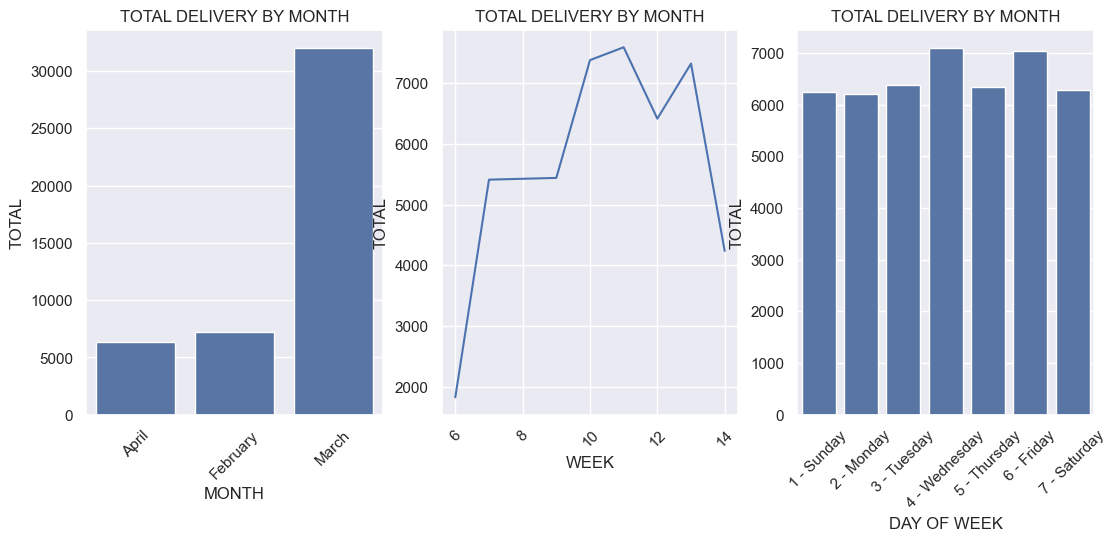

In [44]:
plt.subplot(1,3,1)
aux = df5.groupby(['order_day_month'])['id'].count().reset_index()
sns.barplot( data = aux, x = 'order_day_month', y = 'id')
plt.xlabel('MONTH')
plt.ylabel('TOTAL')
plt.title('TOTAL DELIVERY BY MONTH')
plt.xticks(rotation=45)

plt.subplot(1,3,2)
aux1 = df5.groupby(['number_week'])['id'].count().reset_index()
sns.lineplot( data = aux1, x = 'number_week', y = 'id')
plt.xlabel('WEEK')
plt.ylabel('TOTAL')
plt.title('TOTAL DELIVERY BY MONTH')
plt.xticks(rotation=45)

plt.subplot(1,3,3)
aux2 = df5.groupby(['order_day_week'])['id'].count().reset_index()
sns.barplot( data = aux2, x = 'order_day_week', y = 'id')
plt.xlabel('DAY OF WEEK')
plt.ylabel('TOTAL')
plt.title('TOTAL DELIVERY BY MONTH')
plt.xticks(rotation=45)

plt.show()


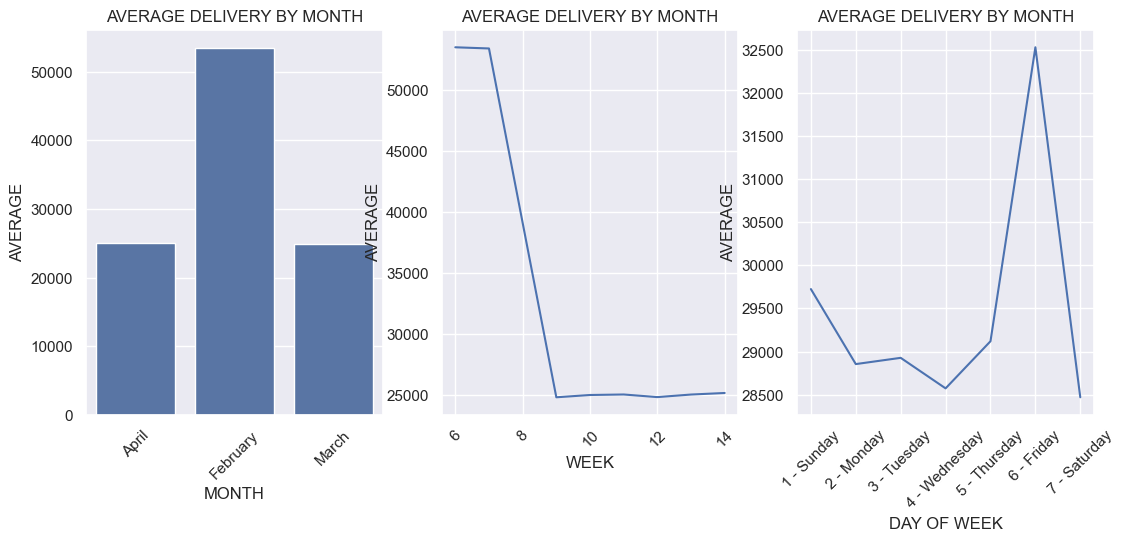

In [45]:
plt.subplot(1,3,1)
aux = df5.groupby(['order_day_month'])['id'].mean().reset_index()
sns.barplot( data = aux, x = 'order_day_month', y = 'id')
plt.xlabel('MONTH')
plt.ylabel('AVERAGE')
plt.title('AVERAGE DELIVERY BY MONTH')
plt.xticks(rotation=45)

plt.subplot(1,3,2)
aux1 = df5.groupby(['number_week'])['id'].mean().reset_index()
sns.lineplot( data = aux1, x = 'number_week', y = 'id')
plt.xlabel('WEEK')
plt.ylabel('AVERAGE')
plt.title('AVERAGE DELIVERY BY MONTH')
plt.xticks(rotation=45)

plt.subplot(1,3,3)
aux2 = df5.groupby(['order_day_week'])['id'].mean().reset_index()
sns.lineplot( data = aux2, x = 'order_day_week', y = 'id')
plt.xlabel('DAY OF WEEK')
plt.ylabel('AVERAGE')
plt.title('AVERAGE DELIVERY BY MONTH')
plt.xticks(rotation=45)

plt.show()

### 5.2.2 - DELIVERIES BY CITY

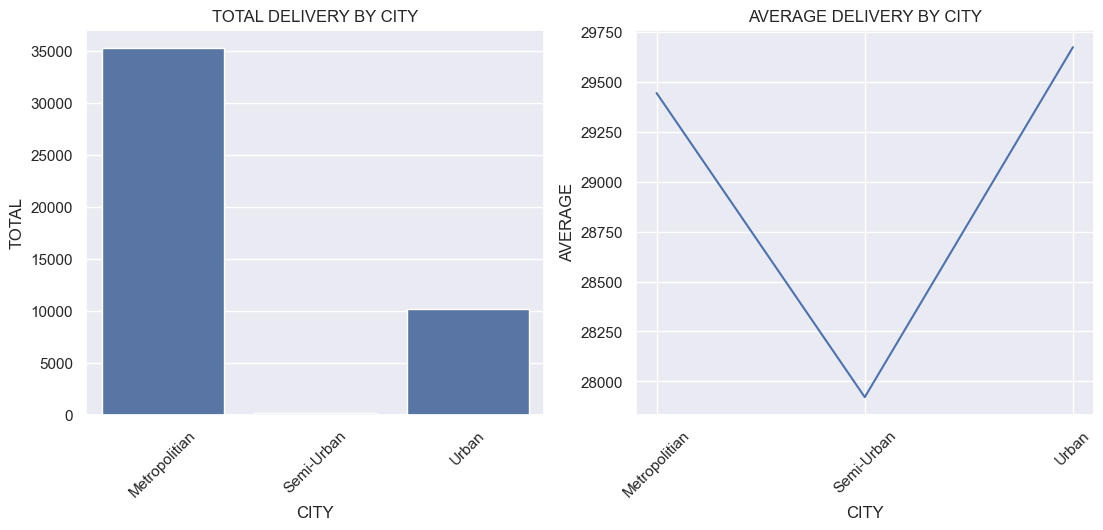

In [46]:
plt.subplot(1,2,1)
aux = df5.groupby(['city'])['id'].count().reset_index()
sns.barplot( data = aux, x = 'city', y = 'id')
plt.xlabel('CITY')
plt.ylabel('TOTAL')
plt.title('TOTAL DELIVERY BY CITY')
plt.xticks(rotation=45)
plt.subplot(1,2,2)
aux = df5.groupby(['city'])['id'].mean().reset_index()
sns.lineplot( data = aux, x = 'city', y = 'id')
plt.xlabel('CITY')
plt.ylabel('AVERAGE')
plt.title('AVERAGE DELIVERY BY CITY')
plt.xticks(rotation=45)
plt.show()

### 5.2.3 - DELIVERIES BY TRAFFIC

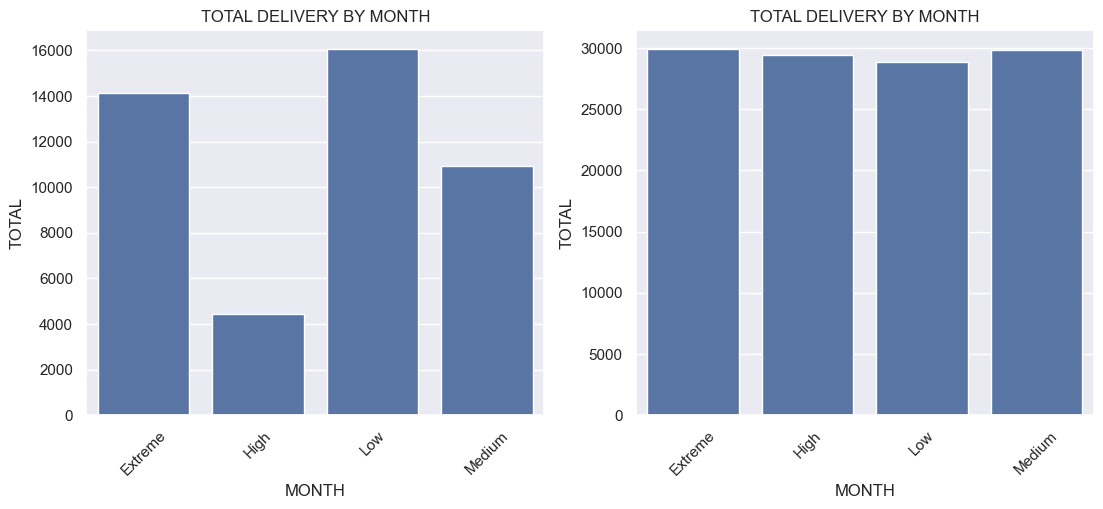

In [47]:
plt.subplot(1,2,1)
aux = df5.groupby(['road_traffic_density'])['id'].count().reset_index()
sns.barplot( data = aux, x = 'road_traffic_density', y = 'id')
plt.xlabel('MONTH')
plt.ylabel('TOTAL')
plt.title('TOTAL DELIVERY BY MONTH')
plt.xticks(rotation=45)
plt.subplot(1,2,2)
aux = df5.groupby(['road_traffic_density'])['id'].mean().reset_index()
sns.barplot( data = aux, x = 'road_traffic_density', y = 'id')
plt.xlabel('MONTH')
plt.ylabel('TOTAL')
plt.title('TOTAL DELIVERY BY MONTH')
plt.xticks(rotation=45)
plt.show()

### 5.2.4 - DELIVERIES BY VEHICLE

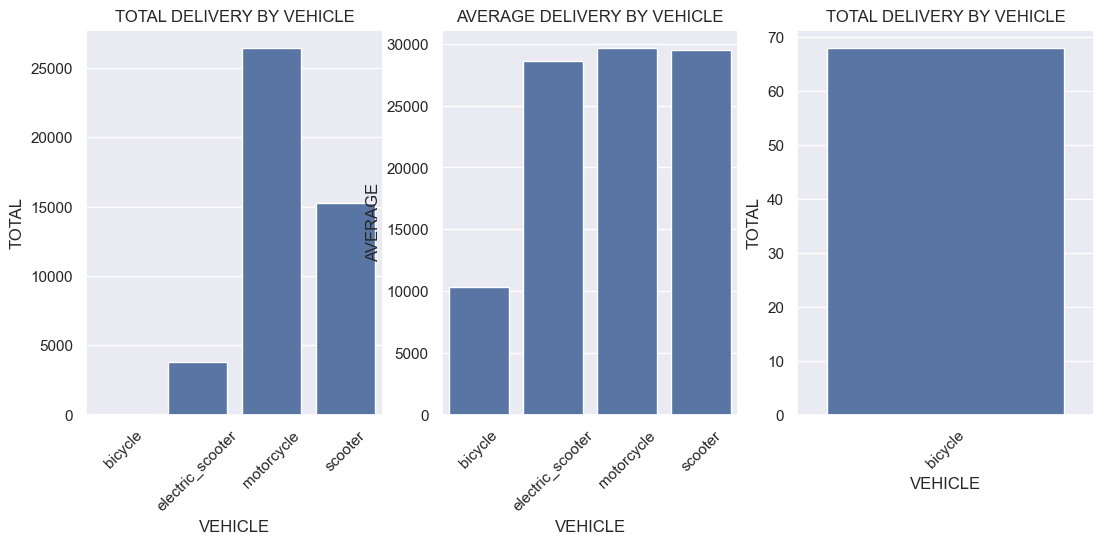

In [48]:
plt.subplot(1,3,1)
aux = df5.groupby(['type_of_vehicle'])['id'].count().reset_index()
sns.barplot( data = aux, x = 'type_of_vehicle', y = 'id')
plt.xlabel('VEHICLE')
plt.ylabel('TOTAL')
plt.title('TOTAL DELIVERY BY VEHICLE')
plt.xticks(rotation=45)
plt.subplot(1,3,2)
aux = df5.groupby(['type_of_vehicle'])['id'].mean().reset_index()
sns.barplot( data = aux, x = 'type_of_vehicle', y = 'id')
plt.xlabel('VEHICLE')
plt.ylabel('AVERAGE')
plt.title('AVERAGE DELIVERY BY VEHICLE')
plt.xticks(rotation=45)
plt.subplot(1,3,3)
df_aux = df5[df5['type_of_vehicle'] == 'bicycle']
aux = df_aux.groupby(['type_of_vehicle'])['id'].count().reset_index()
sns.barplot( data = aux, x = 'type_of_vehicle', y = 'id')
plt.xlabel('VEHICLE')
plt.ylabel('TOTAL')
plt.title('TOTAL DELIVERY BY VEHICLE')
plt.xticks(rotation=45)

plt.show()

### 5.2.5 - DELIVERIES BY TYPE OF ORDER

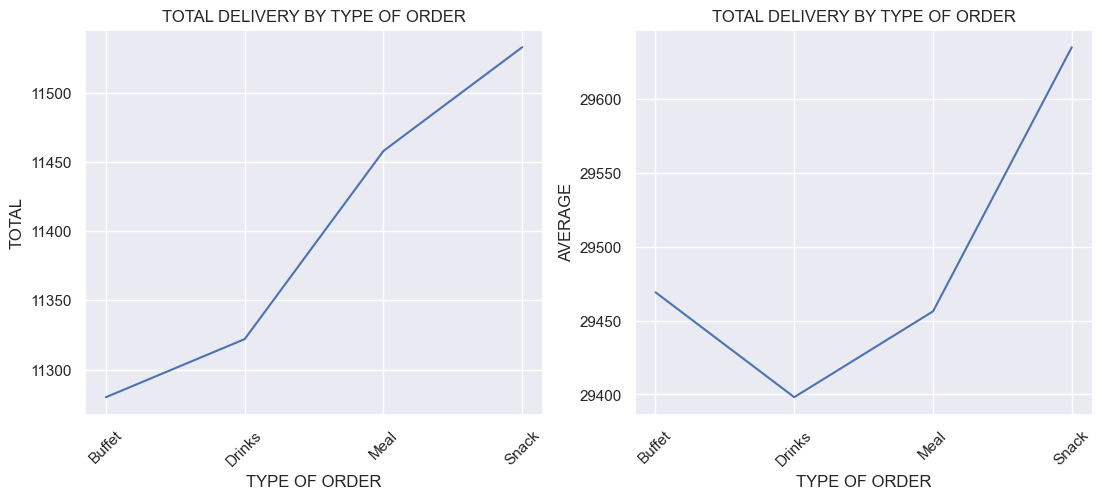

In [49]:
plt.subplot(1,2,1)
aux = df5.groupby(['type_of_order'])['id'].count().reset_index()
sns.lineplot( data = aux, x = 'type_of_order', y = 'id')
plt.xlabel('TYPE OF ORDER')
plt.ylabel('TOTAL')
plt.title('TOTAL DELIVERY BY TYPE OF ORDER')
plt.xticks(rotation=45)
plt.subplot(1,2,2)
aux = df5.groupby(['type_of_order'])['id'].mean().reset_index()
sns.lineplot( data = aux, x = 'type_of_order', y = 'id')
plt.xlabel('TYPE OF ORDER')
plt.ylabel('AVERAGE')
plt.title('TOTAL DELIVERY BY TYPE OF ORDER')
plt.xticks(rotation=45)
plt.show()

### 5.2.6 - DELIVERY TIME BY VEHICLE

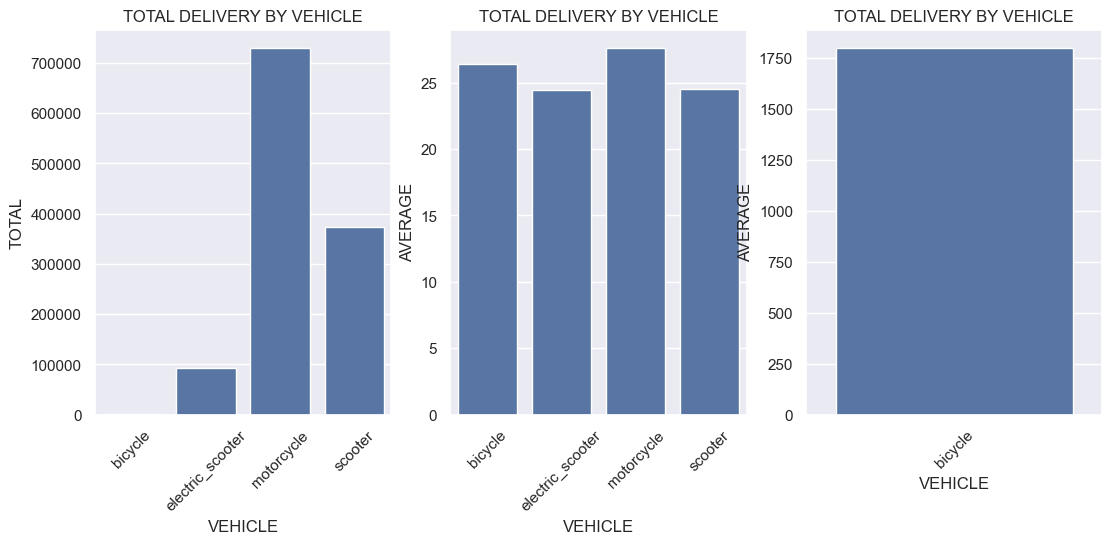

In [50]:
plt.subplot(1,3,1)
aux = df5.groupby(['type_of_vehicle'])['time_taken(min)'].sum().reset_index()
sns.barplot( data = aux, x = 'type_of_vehicle', y = 'time_taken(min)')
plt.xlabel('VEHICLE')
plt.ylabel('TOTAL')
plt.title('TOTAL DELIVERY BY VEHICLE')
plt.xticks(rotation=45)

plt.subplot(1,3,2)
aux = df5.groupby(['type_of_vehicle'])['time_taken(min)'].mean().reset_index()
sns.barplot( data = aux, x = 'type_of_vehicle', y = 'time_taken(min)')
plt.xlabel('VEHICLE')
plt.ylabel('AVERAGE')
plt.title('TOTAL DELIVERY BY VEHICLE')
plt.xticks(rotation=45)

plt.subplot(1,3,3)
df_aux = df5[df5['type_of_vehicle'] == 'bicycle']
aux = df_aux.groupby(['type_of_vehicle'])['time_taken(min)'].sum().reset_index()
sns.barplot( data = aux, x = 'type_of_vehicle', y = 'time_taken(min)')
plt.xlabel('VEHICLE')
plt.ylabel('AVERAGE')
plt.title('TOTAL DELIVERY BY VEHICLE')
plt.xticks(rotation=45)

plt.show()

### 5.2.7 - DELIVERY TIME BY CITY

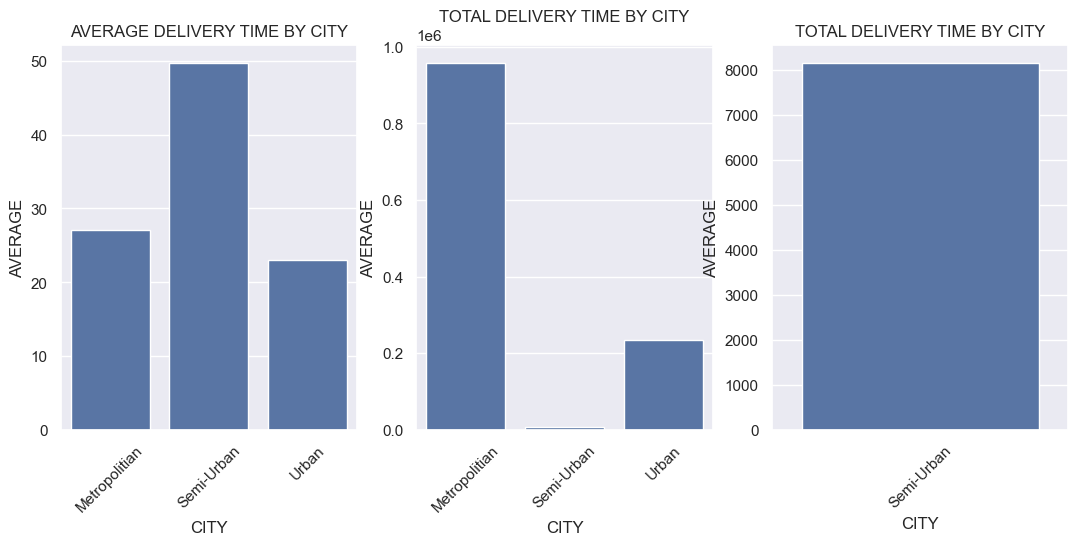

In [51]:
plt.subplot(1,3,1)
aux = df5.groupby(['city'])['time_taken(min)'].mean().reset_index()
sns.barplot( data = aux, x = 'city', y = 'time_taken(min)')
plt.xlabel('CITY')
plt.ylabel('AVERAGE')
plt.title('AVERAGE DELIVERY TIME BY CITY')
plt.xticks(rotation=45)

plt.subplot(1,3,2)
aux = df5.groupby(['city'])['time_taken(min)'].sum().reset_index()
sns.barplot( data = aux, x = 'city', y = 'time_taken(min)')
plt.xlabel('CITY')
plt.ylabel('AVERAGE')
plt.title('TOTAL DELIVERY TIME BY CITY')
plt.xticks(rotation=45)

plt.subplot(1,3,3)
df_aux = df5[df5['city'] == 'Semi-Urban']
aux = df_aux.groupby(['city'])['time_taken(min)'].sum().reset_index()
sns.barplot( data = aux, x = 'city', y = 'time_taken(min)')
plt.xlabel('CITY')
plt.ylabel('AVERAGE')
plt.title('TOTAL DELIVERY TIME BY CITY')
plt.xticks(rotation=45)

plt.show()

### 5.2.8 - DELIVERY TIME BY TRAFFIC

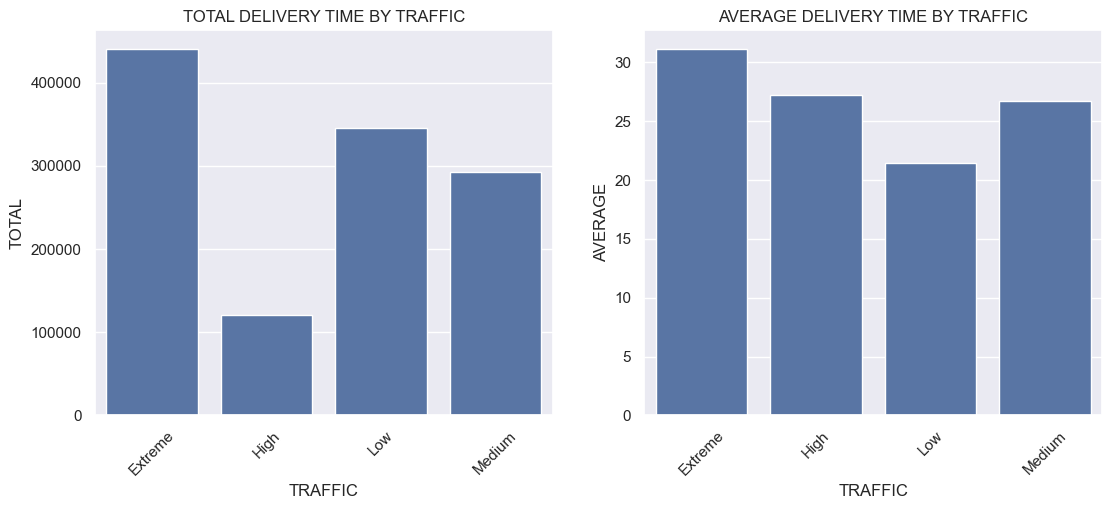

In [52]:
plt.subplot(1,2,1)
aux = df5.groupby(['road_traffic_density'])['time_taken(min)'].sum().reset_index()
sns.barplot( data = aux, x = 'road_traffic_density', y = 'time_taken(min)')
plt.xlabel('TRAFFIC')
plt.ylabel('TOTAL')
plt.title('TOTAL DELIVERY TIME BY TRAFFIC')
plt.xticks(rotation=45)
plt.subplot(1,2,2)
aux = df5.groupby(['road_traffic_density'])['time_taken(min)'].mean().reset_index()
sns.barplot( data = aux, x = 'road_traffic_density', y = 'time_taken(min)')
plt.xlabel('TRAFFIC')
plt.ylabel('AVERAGE')
plt.title('AVERAGE DELIVERY TIME BY TRAFFIC')
plt.xticks(rotation=45)
plt.show()

### 5.2.9 - DELIVERY TIME BY WEATHER CONDITIONS

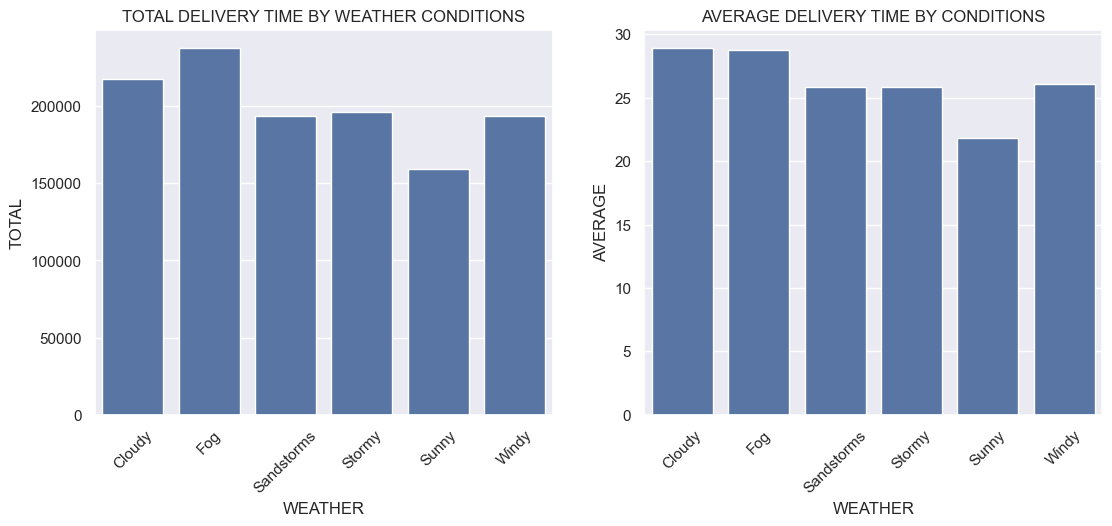

In [53]:
plt.subplot(1,2,1)
aux = df5.groupby(['weather_conditions'])['time_taken(min)'].sum().reset_index()
sns.barplot( data = aux, x = 'weather_conditions', y = 'time_taken(min)')
plt.xlabel('WEATHER')
plt.ylabel('TOTAL')
plt.title('TOTAL DELIVERY TIME BY WEATHER CONDITIONS')
plt.xticks(rotation=45)
plt.subplot(1,2,2)
aux = df5.groupby(['weather_conditions'])['time_taken(min)'].mean().reset_index()
sns.barplot( data = aux, x = 'weather_conditions', y = 'time_taken(min)')
plt.xlabel('WEATHER')
plt.ylabel('AVERAGE')
plt.title('AVERAGE DELIVERY TIME BY CONDITIONS')
plt.xticks(rotation=45)
plt.show()

### 5.2.10 - RATINGS BY TIME

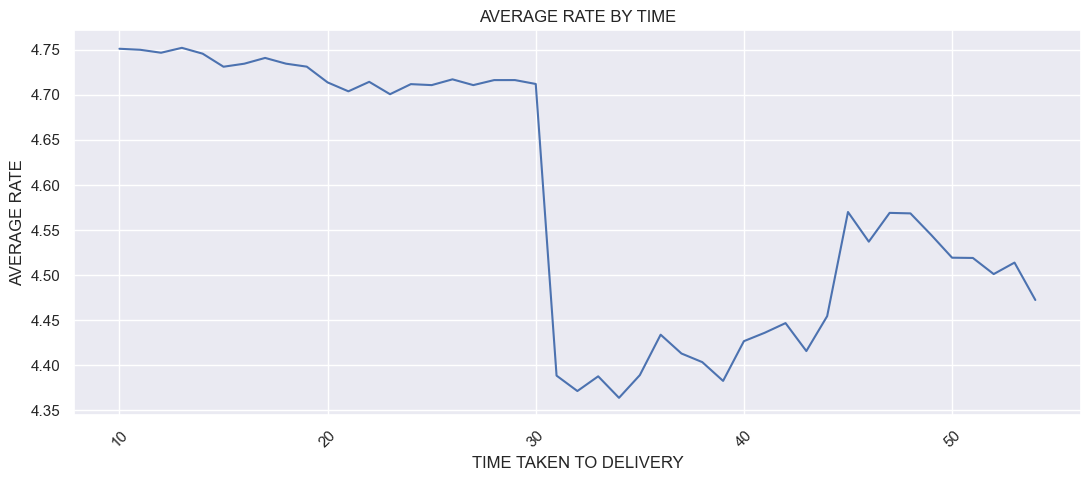

In [54]:
aux = df5.groupby(['time_taken(min)'])['delivery_person_ratings'].mean().reset_index()
sns.lineplot( data = aux, x = 'time_taken(min)', y = 'delivery_person_ratings')
plt.xlabel('TIME TAKEN TO DELIVERY')
plt.ylabel('AVERAGE RATE')
plt.title('AVERAGE RATE BY TIME')
plt.xticks(rotation=45)
plt.show()

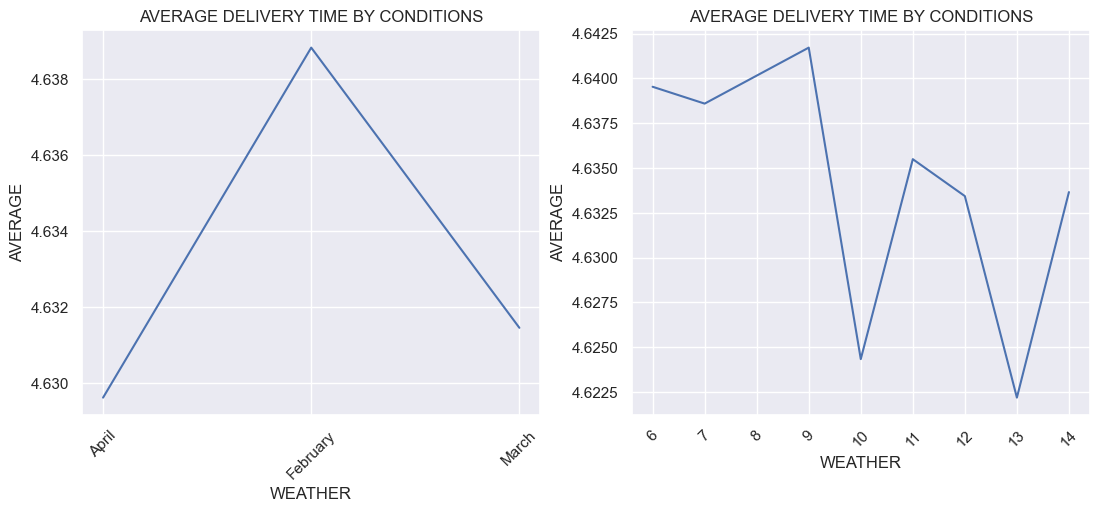

In [55]:
plt.subplot(1,2,1)
aux = df5.groupby(['order_day_month'])['delivery_person_ratings'].mean().reset_index()
sns.lineplot( data = aux, x = 'order_day_month', y = 'delivery_person_ratings')
plt.xlabel('WEATHER')
plt.ylabel('AVERAGE')
plt.title('AVERAGE DELIVERY TIME BY CONDITIONS')
plt.xticks(rotation=45)

plt.subplot(1,2,2)
aux = df5.groupby(['number_week'])['delivery_person_ratings'].mean().reset_index()
sns.lineplot( data = aux, x = 'number_week', y = 'delivery_person_ratings')
plt.xlabel('WEATHER')
plt.ylabel('AVERAGE')
plt.title('AVERAGE DELIVERY TIME BY CONDITIONS')
plt.xticks(rotation=45)

plt.show()

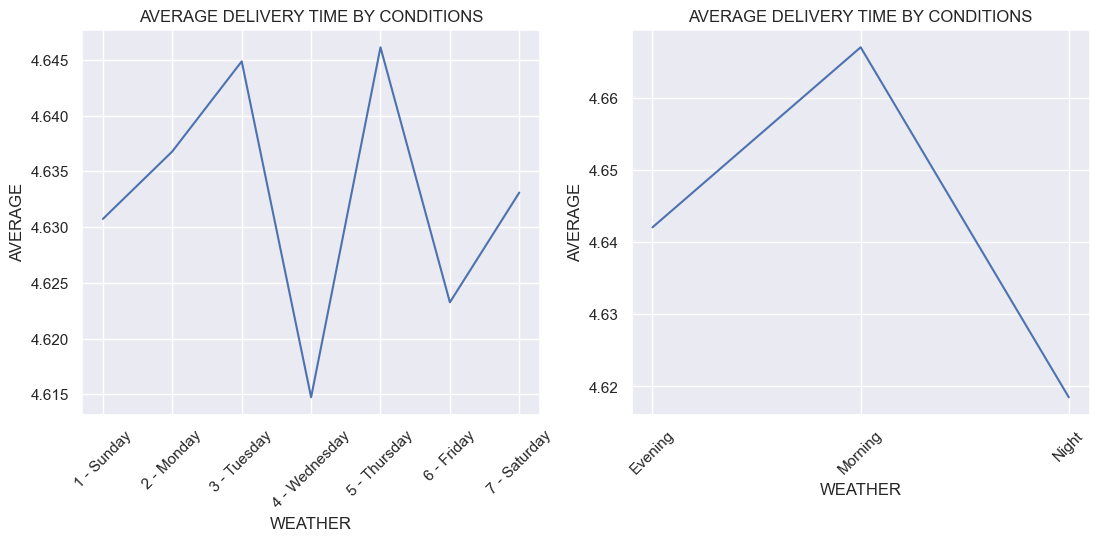

In [56]:
plt.subplot(1,2,1)

aux = df5.groupby(['order_day_week'])['delivery_person_ratings'].mean().reset_index()
sns.lineplot( data = aux, x = 'order_day_week', y = 'delivery_person_ratings')
plt.xlabel('WEATHER')
plt.ylabel('AVERAGE')
plt.title('AVERAGE DELIVERY TIME BY CONDITIONS')
plt.xticks(rotation=45)

plt.subplot(1,2,2)
aux = df5.groupby(['day_period'])['delivery_person_ratings'].mean().reset_index()
sns.lineplot( data = aux, x = 'day_period', y = 'delivery_person_ratings')
plt.xlabel('WEATHER')
plt.ylabel('AVERAGE')
plt.title('AVERAGE DELIVERY TIME BY CONDITIONS')
plt.xticks(rotation=45)

plt.show()

## 5.3 - MULTIVARIATE ANALYSIS

### 5.3.1 - AVERAGE DELIVERY TIME BY SEASONALITY

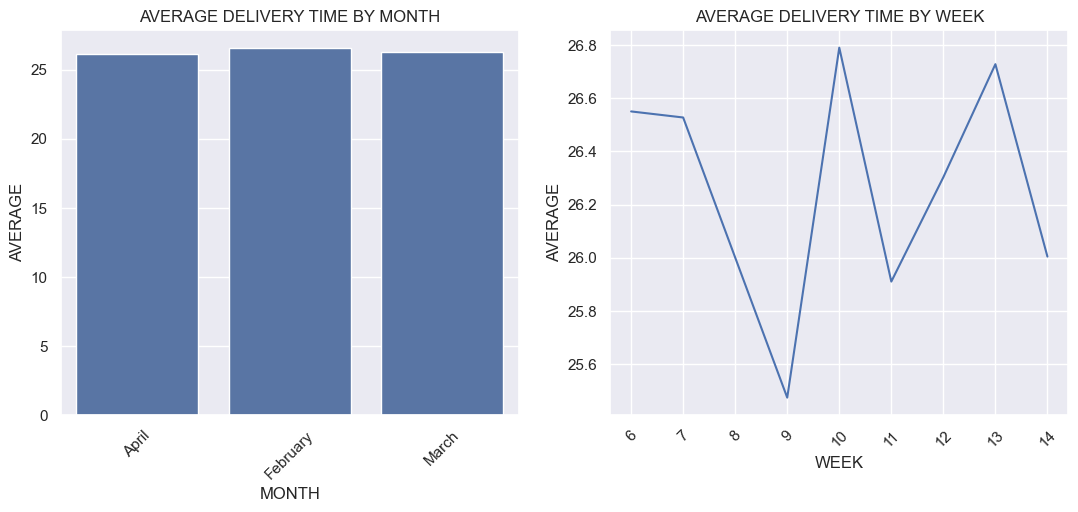

In [57]:
plt.subplot(1,2,1)
aux = df5.groupby(['order_day_month'])['time_taken(min)'].mean().reset_index()
sns.barplot( data = aux, x = 'order_day_month', y = 'time_taken(min)')
plt.xlabel('MONTH')
plt.ylabel('AVERAGE')
plt.title('AVERAGE DELIVERY TIME BY MONTH')
plt.xticks(rotation=45)

plt.subplot(1,2,2)
aux = df5.groupby(['number_week'])['time_taken(min)'].mean().reset_index()
sns.lineplot( data = aux, x = 'number_week', y = 'time_taken(min)')
plt.xlabel('WEEK')
plt.ylabel('AVERAGE')
plt.title('AVERAGE DELIVERY TIME BY WEEK')
plt.xticks(rotation=45)

plt.show()

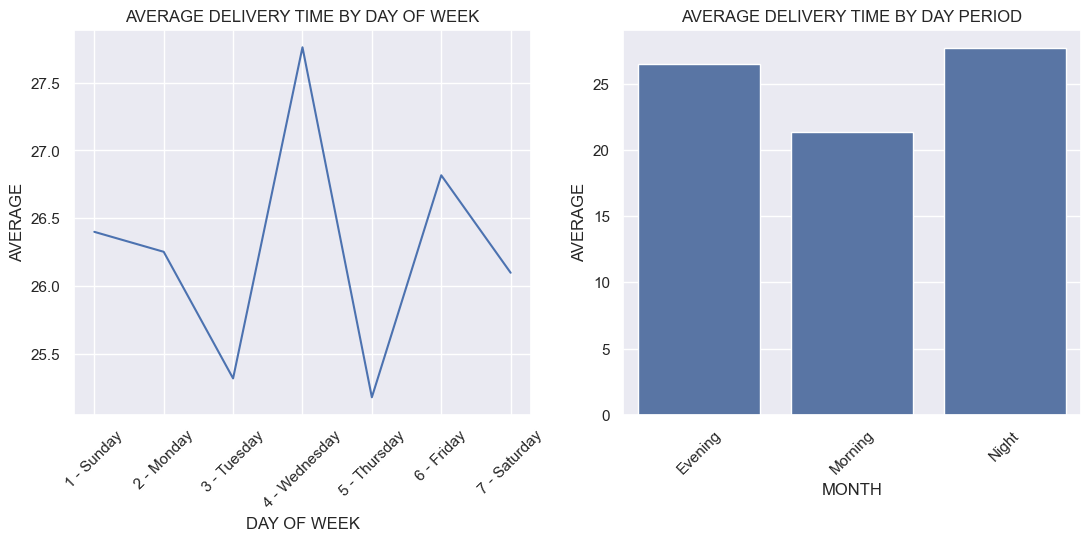

In [58]:
plt.subplot(1,2,1)
aux = df5.groupby(['order_day_week'])['time_taken(min)'].mean().reset_index()
sns.lineplot( data = aux, x = 'order_day_week', y = 'time_taken(min)')
plt.xlabel('DAY OF WEEK')
plt.ylabel('AVERAGE')
plt.title('AVERAGE DELIVERY TIME BY DAY OF WEEK')
plt.xticks(rotation=45)

plt.subplot(1,2,2)
aux = df5.groupby(['day_period'])['time_taken(min)'].mean().reset_index()
sns.barplot( data = aux, x = 'day_period', y = 'time_taken(min)')
plt.xlabel('MONTH')
plt.ylabel('AVERAGE')
plt.title('AVERAGE DELIVERY TIME BY DAY PERIOD')
plt.xticks(rotation=45)

plt.show()

### 5.3.2 - AVERAGE DELIVERY TIME BY SEASONALITY AND TRAFFIC

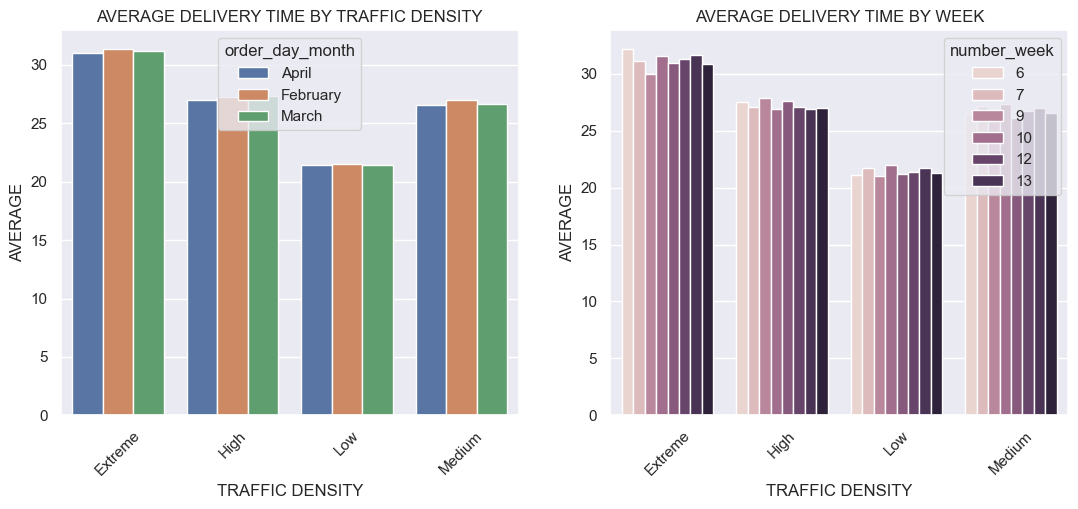

In [59]:
plt.subplot(1,2,1)
aux = df5.groupby(['order_day_month','road_traffic_density'])['time_taken(min)'].mean().reset_index()
sns.barplot( data = aux, x = 'road_traffic_density', y = 'time_taken(min)', hue = 'order_day_month')
plt.xlabel('TRAFFIC DENSITY')
plt.ylabel('AVERAGE')
plt.title('AVERAGE DELIVERY TIME BY TRAFFIC DENSITY')
plt.xticks(rotation=45)

plt.subplot(1,2,2)
aux = df5.groupby(['number_week', 'road_traffic_density'])['time_taken(min)'].mean().reset_index()
sns.barplot( data = aux, x = 'road_traffic_density', y = 'time_taken(min)', hue = 'number_week')
plt.xlabel('TRAFFIC DENSITY')
plt.ylabel('AVERAGE')
plt.title('AVERAGE DELIVERY TIME BY WEEK')
plt.xticks(rotation=45)

plt.show()

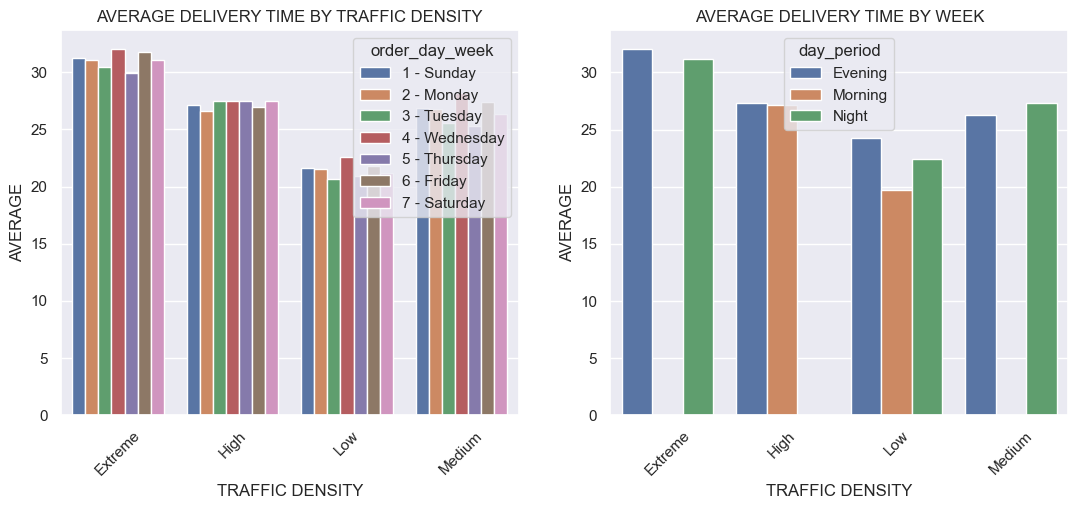

In [60]:
plt.subplot(1,2,1)
aux = df5.groupby(['order_day_week','road_traffic_density'])['time_taken(min)'].mean().reset_index()
sns.barplot( data = aux, x = 'road_traffic_density', y = 'time_taken(min)', hue = 'order_day_week')
plt.xlabel('TRAFFIC DENSITY')
plt.ylabel('AVERAGE')
plt.title('AVERAGE DELIVERY TIME BY TRAFFIC DENSITY')
plt.xticks(rotation=45)

plt.subplot(1,2,2)
aux = df5.groupby(['day_period', 'road_traffic_density'])['time_taken(min)'].mean().reset_index()
sns.barplot( data = aux, x = 'road_traffic_density', y = 'time_taken(min)', hue = 'day_period')
plt.xlabel('TRAFFIC DENSITY')
plt.ylabel('AVERAGE')
plt.title('AVERAGE DELIVERY TIME BY WEEK')
plt.xticks(rotation=45)

plt.show()

### 5.3.3 - AVERAGE DELIVERY TIME BY SEASONALITY AND WEATHER

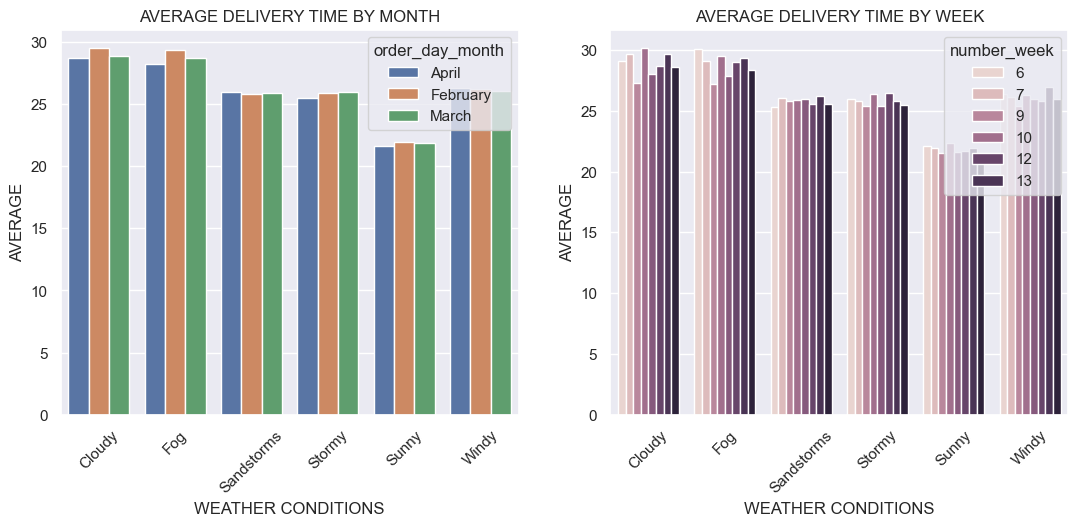

In [61]:
plt.subplot(1,2,1)
aux = df5.groupby(['order_day_month','weather_conditions'])['time_taken(min)'].mean().reset_index()
sns.barplot( data = aux, x = 'weather_conditions', y = 'time_taken(min)', hue = 'order_day_month')
plt.xlabel('WEATHER CONDITIONS')
plt.ylabel('AVERAGE')
plt.title('AVERAGE DELIVERY TIME BY MONTH')
plt.xticks(rotation=45)

plt.subplot(1,2,2)
aux = df5.groupby(['number_week', 'weather_conditions'])['time_taken(min)'].mean().reset_index()
sns.barplot( data = aux, x = 'weather_conditions', y = 'time_taken(min)', hue = 'number_week')
plt.xlabel('WEATHER CONDITIONS')
plt.ylabel('AVERAGE')
plt.title('AVERAGE DELIVERY TIME BY WEEK')
plt.xticks(rotation=45)

plt.show()

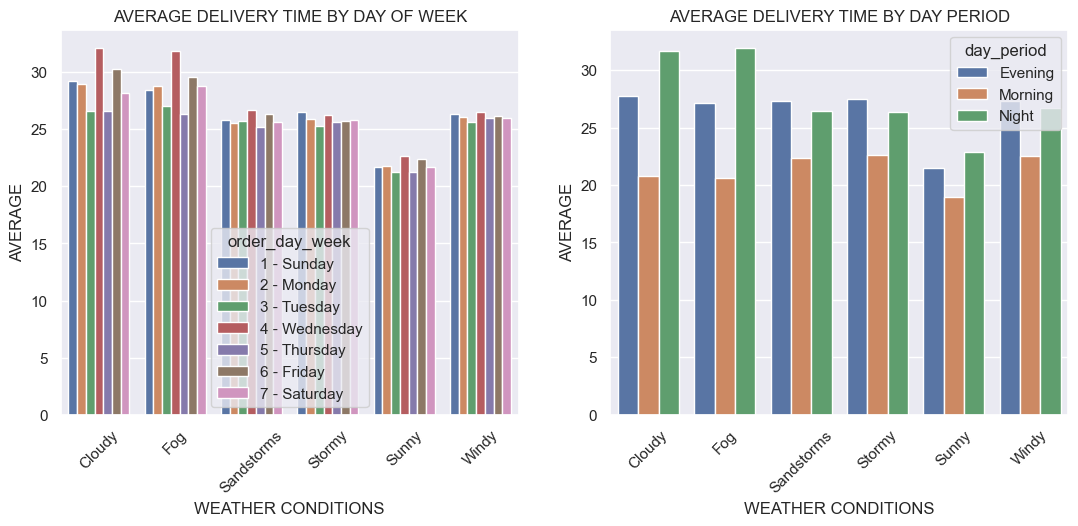

In [62]:
plt.subplot(1,2,1)
aux = df5.groupby(['weather_conditions', 'order_day_week'])['time_taken(min)'].mean().reset_index()
sns.barplot( data = aux, x = 'weather_conditions', y = 'time_taken(min)', hue = 'order_day_week')
plt.xlabel('WEATHER CONDITIONS')
plt.ylabel('AVERAGE')
plt.title('AVERAGE DELIVERY TIME BY DAY OF WEEK')
plt.xticks(rotation=45)

plt.subplot(1,2,2)
aux = df5.groupby(['weather_conditions','day_period'])['time_taken(min)'].mean().reset_index()
sns.barplot( data = aux, x = 'weather_conditions', y = 'time_taken(min)', hue = 'day_period')
plt.xlabel('WEATHER CONDITIONS')
plt.ylabel('AVERAGE')
plt.title('AVERAGE DELIVERY TIME BY DAY PERIOD')
plt.xticks(rotation=45)

plt.show()

### 5.3.4 - AVERAGE DELIVERY TIME BY TYPE OF VEHICLE IN WEATHER CONDITIONS AND TYPE OF TRAFFIC

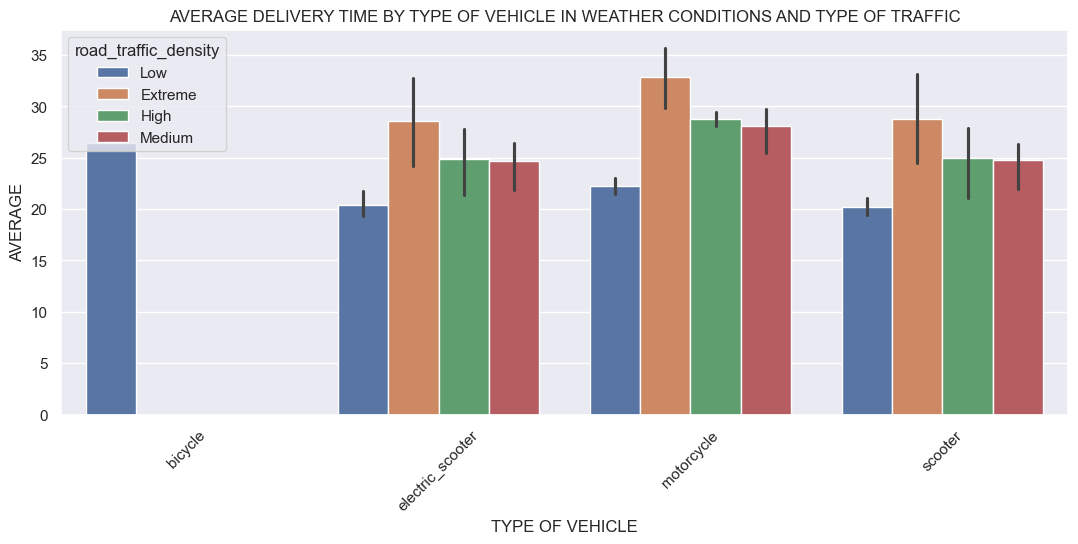

In [63]:
aux = df5.groupby(['type_of_vehicle', 'road_traffic_density','weather_conditions'])['time_taken(min)'].mean().reset_index()
sns.barplot( data = aux, x = 'type_of_vehicle', y = 'time_taken(min)', hue = 'road_traffic_density')
plt.xlabel('TYPE OF VEHICLE')
plt.ylabel('AVERAGE')
plt.title('AVERAGE DELIVERY TIME BY TYPE OF VEHICLE IN WEATHER CONDITIONS AND TYPE OF TRAFFIC')
plt.xticks(rotation=45)

plt.show()

In [64]:
df_map = df5[['city', 'road_traffic_density', 'delivery_location_latitude', 'delivery_location_longitude']].head(10)
map_ = folium.Map()

for index, location in df_map.iterrows():
    folium.Marker([location['delivery_location_latitude'], location['delivery_location_longitude']], popup=f"{location['city']}, Road Traffic Density: {location['road_traffic_density']}").add_to(map_)

map_


# 6.0 - DATA PREPARATION

In [65]:
df6 = df5.copy()

In [66]:
df6['festival'] = df6['festival'].apply(lambda x: 0 if x == 'No' else 1)

Label Encoder

In [67]:
le = LabelEncoder()
df6['city']                        =   le.fit_transform(df6['city'])
df6['day_period']                  =   le.fit_transform(df6['day_period'])
df6['weather_conditions']          =   le.fit_transform(df6['weather_conditions'])
df6['road_traffic_density']        =   le.fit_transform(df6['road_traffic_density'])
df6['type_of_vehicle']             =   le.fit_transform(df6['type_of_vehicle'])
df6['order_day_week']              =   le.fit_transform(df6['order_day_week'])

MinMaxScaler

In [68]:
mms = MinMaxScaler()
df6['time_taken(min)']	= mms.fit_transform(df6['time_taken(min)'].values.reshape(-1, 1))
df6['delivery_location_latitude'] = mms.fit_transform(df6['delivery_location_latitude'].values.reshape(-1, 1))
df6['delivery_location_longitude'] = mms.fit_transform(df6['delivery_location_longitude'].values.reshape(-1, 1))

# 7.0 - FEATURE SELECTION

In [69]:
df7 = df6.copy()

In [70]:
df7 = df6[['city', 'day_period', 'weather_conditions', 'road_traffic_density', 'order_day_week','type_of_vehicle', 'vehicle_condition', 'delivery_person_ratings', 'delivery_location_longitude', 'delivery_location_latitude', 'festival', 'time_taken(min)']]

# 8.0 - MACHINE LEARNING MODEL

## 8.1 - TRAIN TEST SPLIT

In [71]:
df8 = df7.copy()

In [72]:
x = df8.loc[:, ['day_period', 'order_day_week','road_traffic_density', 'type_of_vehicle', 'weather_conditions', 'festival', 'delivery_location_longitude', 'delivery_location_latitude']].values
y = df8['time_taken(min)'].values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

## 8.2 - LINEAR REGRESSION

In [73]:
lr = LinearRegression()
lr.fit(x_train, y_train)
yhat = lr.predict(x_test)

In [74]:
mean_absolute_error(y_test, yhat)

0.15676444198218892

In [75]:
mean_absolute_percentage_error(y_test, yhat)

25217983342432.63

In [76]:
mean_squared_error(y_test, yhat)

0.037036303897326595

In [77]:
r2_score(y_test, yhat)

0.18221021773067636

## 8.3 - RANDOM FOREST

In [78]:
rf = RandomForestRegressor(n_estimators=1000, random_state = 42, n_jobs = -1, max_depth = 20, min_samples_split = 10, min_samples_leaf = 5, max_features = 10)
rf.fit(x_train, y_train)
rf_yhat = rf.predict(x_test)


In [79]:
mean_absolute_error(y_test, rf_yhat)

0.12624441158626198

In [80]:
mean_absolute_percentage_error(y_test, rf_yhat)

18043561531338.793

In [81]:
mean_squared_error(y_test, rf_yhat)

0.02553347712807366

In [82]:
r2_score(y_test, rf_yhat)

0.43620138880398973